In [1]:
import os, sys
from pathlib import Path

project_path = Path(os.getcwd())
sys.path.append(str(project_path) +'/')

data_path = project_path/'data'/'morphomnist'/'global'

In [2]:
import torch
from torch.utils.data import DataLoader,random_split
import math
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import pickle
from mmnist import mmnist
from utils.helpers import EarlyStopper

In [3]:
from utils.datasets import MorphomnistDataset
from utils.visualize import grid_show
from torchvision import transforms 
from utils.customTransforms import ToFloatMNIST

batch_size = 64
dataset = MorphomnistDataset(data_path, transforms.Compose([ToFloatMNIST(),transforms.ToTensor()]), gz=True)

In [4]:
m =len(dataset)
train_data, val_data = random_split(dataset, [math.floor(m-m*0.2), math.ceil(m*0.2)], generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_data, batch_size=batch_size)
val_loader = DataLoader(val_data, batch_size=batch_size)

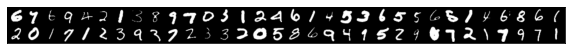

In [5]:
grid_show(next(iter(train_loader))[0])

## Train AE

In [6]:
encoded_dim = 32

model = mmnist(encoded_dim)
losses = {'mse_train_loss':[],'mse_val_loss':[],'nll_train_loss':[],'nll_val_loss':[]}

Selected device: cuda


In [7]:
early_stopper = EarlyStopper(patience=3, min_delta=0.00005)

for epoch in (pbar := tqdm(range(500))):
    mse_train_loss = model.train_ae(train_loader, lr=0.001)
    mse_val_loss = model.test_MSE(val_loader)
    
    losses['mse_train_loss'].append(mse_train_loss)    
    losses['mse_val_loss'].append(mse_val_loss)
    
    if early_stopper.early_stop(mse_val_loss):             
        break    
        
    pbar.set_description(f"mse_train: {mse_train_loss:.6f}, mse_val: {losses['mse_val_loss'][-1]:.6f}")

  0%|          | 0/500 [00:00<?, ?it/s]

(0.0, 0.05)

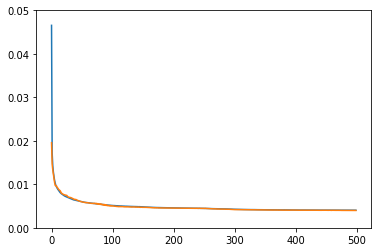

In [8]:
plt.plot(losses['mse_train_loss'])
plt.plot(losses['mse_val_loss'])
plt.ylim([0,0.05])

## Train Flow

In [9]:
early_stopper = EarlyStopper(patience=3, min_delta=0.1)

for epoch in (pbar := tqdm(range(300))):
    nll_train_loss = model.train_macaw(train_loader, lr=0.0001)
    nll_val_loss = model.test_likelihood(val_loader)
    
    losses['nll_train_loss'].append(nll_train_loss)
    losses['nll_val_loss'].append(nll_val_loss)
    
    if early_stopper.early_stop(nll_val_loss):             
        break
        
    pbar.set_description(f"nll_train: {nll_train_loss:.3f}, nll_val: {losses['nll_val_loss'][-1]:.3f}")

  0%|          | 0/300 [00:00<?, ?it/s]

In [10]:
with open(project_path/'models'/'MMNIST_model.pkl', 'wb') as f:
    pickle.dump({'model':model, 'losses':losses}, f)

## Counterfactulas

label 0
thickness 2
slant 0.3


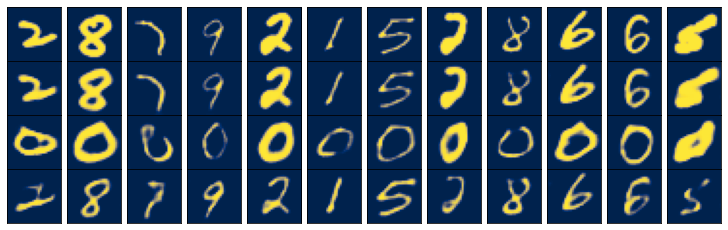

In [12]:
model.cf_test(val_loader)

In [1]:
import numpy as np
import torch
import torch.distributions as td
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler

from macaw.flows import Flow, NormalizingFlowModel

import sys
import os
sys.path.append('../UNIT')
from networks_update import Decoder


class macaw_mapping:

    def __init__(self, encoded_dim, lr=0.005, weight_decay=1e-6):
        self.encoded_dim = encoded_dim

        self.device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
        print(f'Selected device: {self.device}')

        self.macaw = self._init_macaw()

        self.feature_mean = None
        self.feature_std = None

        self.optimizer = torch.optim.Adam(self.macaw.parameters(), lr=lr, weight_decay=weight_decay)


    def _init_macaw(self):
    
        n_layers = 1
        hidden = [2, 4, 2]

        self.num_nodes = 5
        self.num_species = 2

        self.gm_node = 2
        self.wm_node = 3
        self.csf_node = 4

        # define connections between graph nodes
        #   1: species, 2: gm, 3: wm, 4: csf, 5-3605: latents
        species_to_latents = [(s, i) for s in range(self.num_species) for i in range(self.num_nodes, self.encoded_dim + self.num_nodes)]
        labels_to_gm = [(s, self.gm_node) for s in range(self.num_species)]
        labels_to_wm = [(s, self.wm_node) for s in range(self.num_species)]
        labels_to_csf = [(s, self.csf_node) for s in range(self.num_species)]
        gm_to_wm = [(self.gm_node, self.wm_node)]
        gm_to_latents = [(self.gm_node, i) for i in range(self.num_nodes, self.encoded_dim + self.num_nodes)]
        wm_to_latents = [(self.wm_node, i) for i in range(self.num_nodes, self.encoded_dim + self.num_nodes)]
        csf_to_latents = [(self.csf_node, i) for i in range(self.num_nodes, self.encoded_dim + self.num_nodes)]
        autoregressive_latents = [(i, j) for i in range(self.num_nodes, self.encoded_dim + self.num_nodes) for j in
                                  range(i + 1, self.encoded_dim + self.num_nodes)]

        edges = species_to_latents + labels_to_gm + labels_to_wm + labels_to_csf + gm_to_wm + gm_to_latents + wm_to_latents + csf_to_latents + autoregressive_latents

        priors = [(slice(0, self.num_species), td.OneHotCategorical(0.1 * torch.ones(self.num_species).to(self.device))), # NOTE: what is the 0.1?
                  (slice(self.num_species, self.encoded_dim + self.num_nodes),
                   td.Normal(torch.zeros(self.encoded_dim + self.num_nodes - self.num_species).to(self.device),
                             torch.ones(self.encoded_dim + self.num_nodes - self.num_species).to(self.device))),
                  ]

        flow_list = [Flow(self.encoded_dim + self.num_nodes, edges, self.device, hm=hidden) for _ in range(n_layers)]
        return NormalizingFlowModel(priors, flow_list).to(self.device)

    def _batch_to_x(self, batch):
        flow_batch, features_batch, species_batch = batch[0], batch[1], batch[2]
        species_batch = one_hot(species_batch).to(self.device) # one hot the species
        features_batch = (features_batch.to(self.device) - self.feature_mean) / self.feature_std
        x = torch.hstack([species_batch, features_batch, flow_batch]).type(torch.float32)
        return x, flow_batch

    def _x_to_batch(self, x, latents):
        latents[:, :] = x[:, :self.encoded_dim]
        cfs = latents.detach().cpu().numpy() # also just don't decode here
        labels = inverse_one_hot(x[:, :self.num_species]).detach().cpu().numpy()
        features = (x[:, self.encoded_dim + self.num_species : self.encoded_dim + self.num_nodes] * self.feature_std + self.feature_mean).detach().cpu().numpy()
        return [cfs, features, labels]

    def _compute_feature_mean(self, train_loader):
        features = []
        for b in train_loader:
            features.append(b[1].numpy())
        features = np.vstack(features)
        scaler_f = StandardScaler()
        _ = scaler_f.fit_transform(features)
        self.feature_mean = torch.tensor(scaler_f.mean_).to(self.device)
        self.feature_std = torch.tensor(np.sqrt(scaler_f.var_)).to(self.device)

    def train_macaw(self, train_loader):

        self.macaw.train()

        if self.feature_mean is None:
            self._compute_feature_mean(train_loader)

        loss_val = []
        for batch in train_loader:
            batch = [batch[0].to(self.device), batch[1].to(self.device), batch[2].to(self.device)]
            with torch.no_grad():
                x, _ = self._batch_to_x(batch)

            _, prior_logprob, log_det = self.macaw(x)
            loss = - torch.sum(prior_logprob + log_det)
            loss /= train_loader.batch_size
            loss_val.append(loss.detach().cpu().numpy())

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

        return np.mean(loss_val)

    def test_likelihood(self, dataloader):

        self.macaw.eval()

        loss_val = []
        for batch in dataloader:
            with torch.no_grad():
                batch = [batch[0].to(self.device), batch[1].to(self.device), batch[2].to(self.device)]
                x, _ = self._batch_to_x(batch)

                _, prior_logprob, log_det = self.macaw(x)
                loss = - torch.sum(prior_logprob + log_det)
                loss /= dataloader.batch_size
                loss_val.append(loss.detach().cpu().numpy())

        return np.mean(loss_val)

    def _cf(self, x_obs, cf_vals):
        self.macaw.eval()

        with torch.no_grad():
            z_obs = self.macaw(x_obs)[0][-1]
            x_cf = x_obs.detach().clone()
            for key in cf_vals:
                x_cf[:, key] = cf_vals[key]

            z_cf_val = self.macaw(x_cf)[0][-1]
            for key in cf_vals:
                z_obs[:, key] = z_cf_val[:, key]

        return self.macaw.backward(z_obs)[0][-1]

    def counterfactual(self, batch, cf_vals):
        self.macaw.eval()

        cf_vals = self._cfvals_transform(cf_vals)

        with torch.no_grad():
            batch = [batch[0].to(self.device), batch[1].to(self.device), batch[2].to(self.device)]
            x_obs, latents = self._batch_to_x(batch)
            x_cf = self._cf(x_obs, cf_vals)
            return self._x_to_batch(x_cf, latents)

    def _cfvals_transform(self, cf_vals):
        cfv = {}

        if cf_vals is not None:
            for key in cf_vals:
                #print(key, cf_vals[key])
                if key == 'species':
                    cfv.update({i: int(x) for i, x in enumerate(one_hot(np.array([cf_vals[key]]))[0])})

                if key == 'gm':
                    tf = (torch.tensor([cf_vals[key], 0, 0]).to(self.device) - self.feature_mean) / self.feature_std
                    cfv.update({self.gm_node: tf[0]})
                if key == 'wm':
                    tf = (torch.tensor([0, cf_vals[key], 0]).to(self.device) - self.feature_mean) / self.feature_std
                    cfv.update({self.wm_node: tf[1]})
                if key == 'csf':
                    tf = (torch.tensor([0, 0, cf_vals[key]]).to(self.device) - self.feature_mean) / self.feature_std
                    cfv.update({self.csf_node: tf[2]})

            return cfv
    
    def decode(self, latent):
        decoder_save_folder = "../UNIT/save_2d/human_train_3/"
        decoder_epoch = 1000
        latent_shape = [1, 16, 15,15]

        decoder_trans = Decoder(n_upsample=3, n_res=2, dim=16, output_dim=4)
        decoder_trans.load_state_dict(torch.load(decoder_save_folder + "checkpoint_epoch_" + str(decoder_epoch))['decoder_state_dict'])
        trans_img = decoder_trans(torch.tensor(latent).reshape(latent_shape))
        trans_img = torch.argmax(trans_img, dim=1)
        trans_img = np.array(trans_img.squeeze())

        return trans_img

    def cf_test(self, model, batch, save_path="", nsamples=4):

        batch = [batch[0].to("cuda"), batch[1].to("cuda"), batch[2].to("cuda")]
        real_latents = batch[0].detach().cpu().numpy()

        cf_vals = {}
        cfs_none = model.counterfactual(batch, cf_vals)

        cf_vals = {'species': 1}
        cfs_human = model.counterfactual(batch, cf_vals)

        cf_vals = {'species': 1, 'gm': 0.59}
        cfs_human_large_gm = model.counterfactual(batch, cf_vals)

        # plot grid
        plt.rcParams['figure.figsize'] = (9, 7)
        fig = plt.figure()

        subfigs = fig.subfigures(nrows=4, ncols=1)

        # row 1 - the image
        nsamples = 4
        axs0 = subfigs[0].subplots(nrows=1, ncols=nsamples)
        for i, img in enumerate(real_latents):
            D_img = model.decode(img)
            axs0[i].imshow(D_img, cmap='gray')
            axs0[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[], xlabel=None)
            axs0[i].set_title(["Human test", "Mouse test", "Human train", "Mouse train"][i])
            axs0[i].set_xlabel("gm: " + str(np.round(np.sum(D_img == 1) / (np.sum((D_img == 1) | (D_img == 2) | (D_img == 3)) + 1e-10), 3)))

        # row 2 - 'counterfactual - but no values changed
        axs1 = subfigs[1].subplots(nrows=1, ncols=nsamples)
        for i, img in enumerate(cfs_none[0]):
            D_img = model.decode(img)
            axs1[i].imshow(D_img, cmap='gray')
            axs1[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[], xlabel=None)
            axs1[i].set_xlabel("gm: " + str(np.round(np.sum(D_img == 1) / (np.sum((D_img == 1) | (D_img == 2) | (D_img == 3)) + 1e-10), 3)))


        axs2 = subfigs[2].subplots(nrows=1, ncols=nsamples)
        for i, img in enumerate(cfs_human[0]):
            D_img = model.decode(img)
            axs2[i].imshow(D_img, cmap='gray')
            axs2[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[], xlabel=None)
            axs2[i].set_xlabel("gm: " + str(np.round(np.sum(D_img == 1) / (np.sum((D_img == 1) | (D_img == 2) | (D_img == 3)) + 1e-10), 3)))

        # row 4 - counterfactual - set gm to 0.59 (high end of human distribution)
        axs3 = subfigs[3].subplots(nrows=1, ncols=nsamples)
        for i, img in enumerate(cfs_human_large_gm[0]):
            D_img = model.decode(img)
            axs3[i].imshow(D_img, cmap='gray')
            axs3[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[], xlabel=None)
            axs3[i].set_xlabel("gm: " + str(np.round(np.sum(D_img == 1) / (np.sum((D_img == 1) | (D_img == 2) | (D_img == 3)) + 1e-10), 3)))

        axs0[0].set_ylabel("Decoded_H img")
        axs1[0].set_ylabel("CF no changes")
        axs2[0].set_ylabel("CF -> Human")
        axs3[0].set_ylabel("CF -> H + gm=0.59")
        
        if save_path != "":
            print("save to:", save_path)
            plt.savefig(save_path)
        else:
            plt.show()
            

    def get_optimizer(self):
        return self.optimizer
    
    def get_macaw(self):
        return self.macaw
    
    def load_state(self, state_path):
        self.macaw.load_state_dict(torch.load(state_path)['model_state_dict'])
        self.optimizer.load_state_dict(torch.load(state_path)['optimizer_state_dict'])
        


# default is 2 for num_species
def one_hot(a, veclen=2):
    b = torch.zeros((a.shape[0], veclen))
    b[torch.arange(a.shape[0]), a] = 1
    return b


def inverse_one_hot(b):
    return torch.argmax(b, axis=1)


## Train on latents

In [2]:
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import random

#from macaw_mapping import *
import SimpleITK as sitk
import os
from tqdm.auto import tqdm


In [3]:
# need return format to be: flow_batch, features_batch, species_batch = batch[0], batch[1], batch[2]

class MACAW_data_loader(Dataset):
    def __init__(self, mouse_encodings_folder, human_encodings_folder):
        self.mouse_encodings_folder = mouse_encodings_folder
        self.human_encodings_folder = human_encodings_folder

        self.mouse_encodings_files = os.listdir(mouse_encodings_folder)
        self.human_encodings_files = os.listdir(human_encodings_folder)

        self.paths = ([mouse_encodings_folder + file for file in self.mouse_encodings_files]) + ([human_encodings_folder + file for file in self.human_encodings_files])
        random.seed(0)
        random.shuffle(self.paths) # shuffle to mix up mice and human paths

        # compute wm/gm/csf ratios
        self.features = []
        self.species = []
        for path in self.paths:
            split_path = path.split("/")
            is_mouse = False
            is_test = False

            if split_path[3].split("_")[0] == "mouse":
                self.species.append(0)
                is_mouse = True
            else:
                self.species.append(1)

            is_test = (split_path[4] == "test_latent_encodings")

            img_path = "../UNIT/datasets/2d/" + ("mouse_" if is_mouse else "human_") + ("test/" if is_test else "train/") + split_path[-1][8:-3]
            print(img_path)

            img_arr = sitk.GetArrayFromImage(sitk.ReadImage(img_path))

            gm_count = np.sum(img_arr == 1)
            wm_count = np.sum(img_arr == 2)
            csf_count = np.sum(img_arr == 3)
            total_count = gm_count + wm_count + csf_count

            ratios = []
            ratios.append(gm_count/total_count)
            ratios.append(wm_count/total_count)
            ratios.append(csf_count/total_count)

            self.features.append(ratios)
        
        self.features = torch.tensor(self.features)
        self.species = torch.tensor(self.species)

    
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        latent_encoding = torch.load(self.paths[idx]).detach().flatten()
        features = self.features[idx]
        species = self.species[idx]

        return [latent_encoding, features, species]
    
    def get_s_a_f(self):
        return self.species, self.features

In [4]:

# load data into random ordered vectors
mouse_encodings_folder = "../UNIT/save_2d/mouse_train_3/train_latent_encodings/"
human_encodings_folder = "../UNIT/save_2d/human_train_3/train_latent_encodings/"

mouse_encodings_folder_test = "../UNIT/save_2d/mouse_train_3/test_latent_encodings/"
human_encodings_folder_test = "../UNIT/save_2d/human_train_3/test_latent_encodings/"

batch_size = 4

dataset_train = MACAW_data_loader(mouse_encodings_folder, human_encodings_folder)
train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=False, num_workers=4)

dataset_test = MACAW_data_loader(mouse_encodings_folder_test, human_encodings_folder_test)
val_loader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False, num_workers=4)

../UNIT/datasets/2d/human_train/sub-1033244_n4.nii
../UNIT/datasets/2d/human_train/sub-1056494_n4.nii
../UNIT/datasets/2d/mouse_train/18534_05_RARE_labels_GMWM.nii
../UNIT/datasets/2d/human_train/sub-1028317_n4.nii
../UNIT/datasets/2d/human_train/sub-1034827_n4.nii
../UNIT/datasets/2d/mouse_train/BRF19074_03_RARE_labels_GMWM.nii
../UNIT/datasets/2d/human_train/sub-1011640_n4.nii
../UNIT/datasets/2d/human_train/sub-1051005_n4.nii
../UNIT/datasets/2d/human_train/sub-1070244_n4.nii
../UNIT/datasets/2d/human_train/sub-1025911_n4.nii
../UNIT/datasets/2d/mouse_train/BRF4928_02_RARE_labels_GMWM.nii
../UNIT/datasets/2d/mouse_train/BRF19127_06_RARE_labels_GMWM.nii
../UNIT/datasets/2d/mouse_train/BRF4948_03_RARE_labels_GMWM.nii
../UNIT/datasets/2d/mouse_train/18346_04_RARE_labels_GMWM.nii
../UNIT/datasets/2d/human_train/sub-1025436_n4.nii
../UNIT/datasets/2d/mouse_train/18092_05_RARE_labels_GMWM.nii
../UNIT/datasets/2d/human_train/sub-1025750_n4.nii
../UNIT/datasets/2d/human_train/sub-1060029_n4

In [5]:
encoded_dim = 3600 # fits 3000!

model = macaw_mapping(encoded_dim, lr=0.001)
#model.load_state('../UNIT/save_2d/mapping_models/macaw.pth')
losses = {'mse_train_loss':[],'mse_val_loss':[],'nll_train_loss':[],'nll_val_loss':[]}

Selected device: cuda


In [6]:
from torch.utils.data._utils.collate import default_collate

mouse_test = dataset_test.__getitem__(3) 
human_test = dataset_test.__getitem__(0) 
mouse_train = dataset_train.__getitem__(2) 
human_train = dataset_train.__getitem__(1) 


test_imgs_batch = default_collate([mouse_test, human_test, mouse_train, human_train])
print(test_imgs_batch)

[tensor([[ 0.8037,  0.2608,  0.3858,  ...,  0.0275, -0.0226,  0.0086],
        [ 2.6722,  3.4804,  3.7403,  ..., -0.9404, -1.6006, -0.0362],
        [ 0.8224,  0.2690,  0.3233,  ..., -0.1396, -0.1559,  0.1542],
        [ 1.8897,  1.8315,  4.0617,  ..., -0.7114, -1.4490, -0.1462]]), tensor([[0.8725, 0.0912, 0.0363],
        [0.5505, 0.4087, 0.0408],
        [0.8905, 0.0986, 0.0109],
        [0.5725, 0.3711, 0.0565]], dtype=torch.float64), tensor([0, 1, 0, 1])]


In [ ]:
save_img_freq = 20
save_checkpoint_freq = 50
imgs_save_path = "./save_models/train_1/test_imgs/"
checkpoints_save_path = "./save_models/train_1/checkpoints/"

for epoch in (pbar := tqdm(range(500))):
    nll_train_loss = model.train_macaw(train_loader)
    nll_val_loss = model.test_likelihood(val_loader)
    
    losses['nll_train_loss'].append(nll_train_loss)
    losses['nll_val_loss'].append(nll_val_loss)
        
    pbar.set_description(f"nll_train: {nll_train_loss:.3f}, nll_val: {losses['nll_val_loss'][-1]:.3f}")

    if epoch % save_img_freq == 0:
        print("saving imgs...")
        model.cf_test(model, test_imgs_batch, save_path=(imgs_save_path + "epoch_" + str(epoch)))
        print("done")

    
    if epoch % save_checkpoint_freq == 0:
        torch.save({
            'model_state_dict': model.get_macaw().state_dict(),
            'optimizer_state_dict': model.get_optimizer().state_dict()
        }, checkpoints_save_path + "epoch_" + str(epoch) + ".pth")


  0%|          | 0/500 [00:00<?, ?it/s]

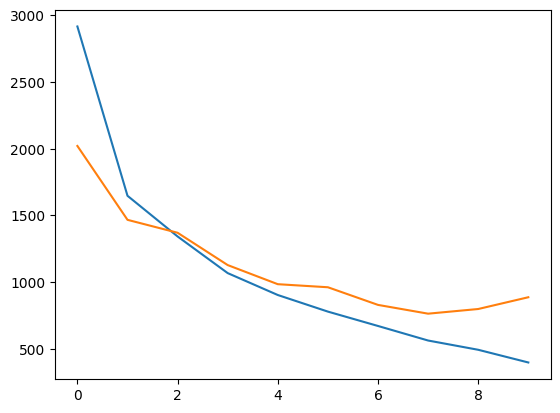

In [5]:
plt.plot(losses['nll_train_loss'])
plt.plot(losses['nll_val_loss'])

In [6]:
torch.save({
    'model_state_dict': model.get_macaw().state_dict(),
    'optimizer_state_dict': model.get_optimizer().state_dict()
}, '../UNIT/save_2d/mapping_models/macaw.pth')

species 1
gm 0.59


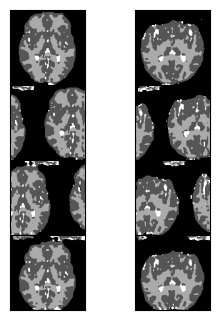

In [9]:
model._compute_feature_mean(train_loader)
model.cf_test(model, val_loader)

In [12]:
model._compute_feature_mean(train_loader)


batch = test_imgs_batch
batch = [batch[0].to("cuda"), batch[1].to("cuda"), batch[2].to("cuda")]
real_latents = batch[0].detach().cpu().numpy()


# row 1 - the image
cf_vals = {}
cfs_none = model.counterfactual(batch, cf_vals)

cf_vals = {'species': 1}
cfs_human = model.counterfactual(batch, cf_vals)

cf_vals = {'species': 1, 'gm': 0.59}
cfs_human_large_gm = model.counterfactual(batch, cf_vals)


species 1
species 1
gm 0.59


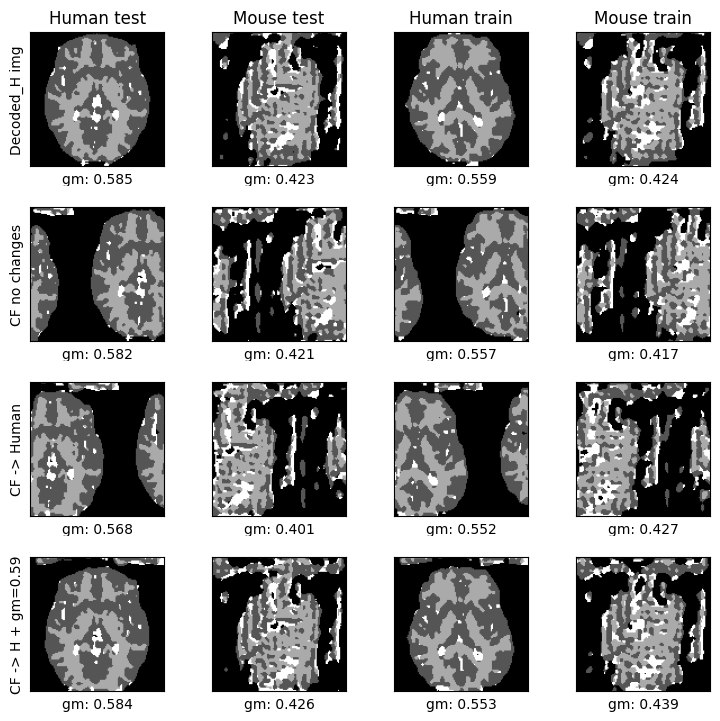

In [ ]:
plt.rcParams['figure.figsize'] = (9, 7)
fig = plt.figure()

subfigs = fig.subfigures(nrows=4, ncols=1)

# row 1 - the image
nsamples = 4
axs0 = subfigs[0].subplots(nrows=1, ncols=nsamples)
for i, img in enumerate(real_latents):
    D_img = model.decode(img)
    axs0[i].imshow(D_img, cmap='gray')
    axs0[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[], xlabel=None)
    axs0[i].set_title(["Human test", "Mouse test", "Human train", "Mouse train"][i])
    axs0[i].set_xlabel("gm: " + str(np.round(np.sum(D_img == 1) / np.sum((D_img == 1) | (D_img == 2) | (D_img == 3)), 3)))

# row 2 - 'counterfactual - but no values changed
axs1 = subfigs[1].subplots(nrows=1, ncols=nsamples)
for i, img in enumerate(cfs_none[0]):
    D_img = model.decode(img)
    axs1[i].imshow(D_img, cmap='gray')
    axs1[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[], xlabel=None)
    axs1[i].set_xlabel("gm: " + str(np.round(np.sum(D_img == 1) / np.sum((D_img == 1) | (D_img == 2) | (D_img == 3)), 3)))


axs2 = subfigs[2].subplots(nrows=1, ncols=nsamples)
for i, img in enumerate(cfs_human[0]):
    D_img = model.decode(img)
    axs2[i].imshow(D_img, cmap='gray')
    axs2[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[], xlabel=None)
    axs2[i].set_xlabel("gm: " + str(np.round(np.sum(D_img == 1) / np.sum((D_img == 1) | (D_img == 2) | (D_img == 3)), 3)))

# row 4 - counterfactual - set gm to 0.59 (high end of human distribution)
axs3 = subfigs[3].subplots(nrows=1, ncols=nsamples)
for i, img in enumerate(cfs_human_large_gm[0]):
    D_img = model.decode(img)
    axs3[i].imshow(D_img, cmap='gray')
    axs3[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[], xlabel=None)
    axs3[i].set_xlabel("gm: " + str(np.round(np.sum(D_img == 1) / np.sum((D_img == 1) | (D_img == 2) | (D_img == 3)), 3)))

axs0[0].set_ylabel("Decoded_H img")
axs1[0].set_ylabel("CF no changes")
axs2[0].set_ylabel("CF -> Human")
axs3[0].set_ylabel("CF -> H + gm=0.59")